# Stereo Vision Pipeline for Disparity Map Estimation

This notebook describes the complete pipeline for computing disparity maps using a stereo camera system.
The goal is to improve the quality and robustness of disparity estimation by refining each processing step,
including camera calibration, image rectification, distortion correction, and post-processing.

The pipeline consists of the following steps:

1. Disparity map computation using StereoSGBM
2. Disparity map computation with hole-filling post-processing
3. Improved camera calibration (estimation of intrinsic parameters and distortion coefficients)
4. Verification and tuning of distortion correction using calibration parameters
5. Image rectification and undistortion
6. Disparity map computation using rectified and undistorted images

Each step is explained below with its purpose and role in the overall pipeline.

### 5. Image Rectification and Undistortion

In this step, stereo image rectification is applied together with undistortion.
Rectification aligns the left and right images so that corresponding points
lie on the same horizontal scanlines.

This transformation simplifies stereo matching by reducing the correspondence problem
to a one-dimensional horizontal search.
Rectification is a critical preprocessing step for accurate disparity estimation.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Estimated vertical shift dy: 2


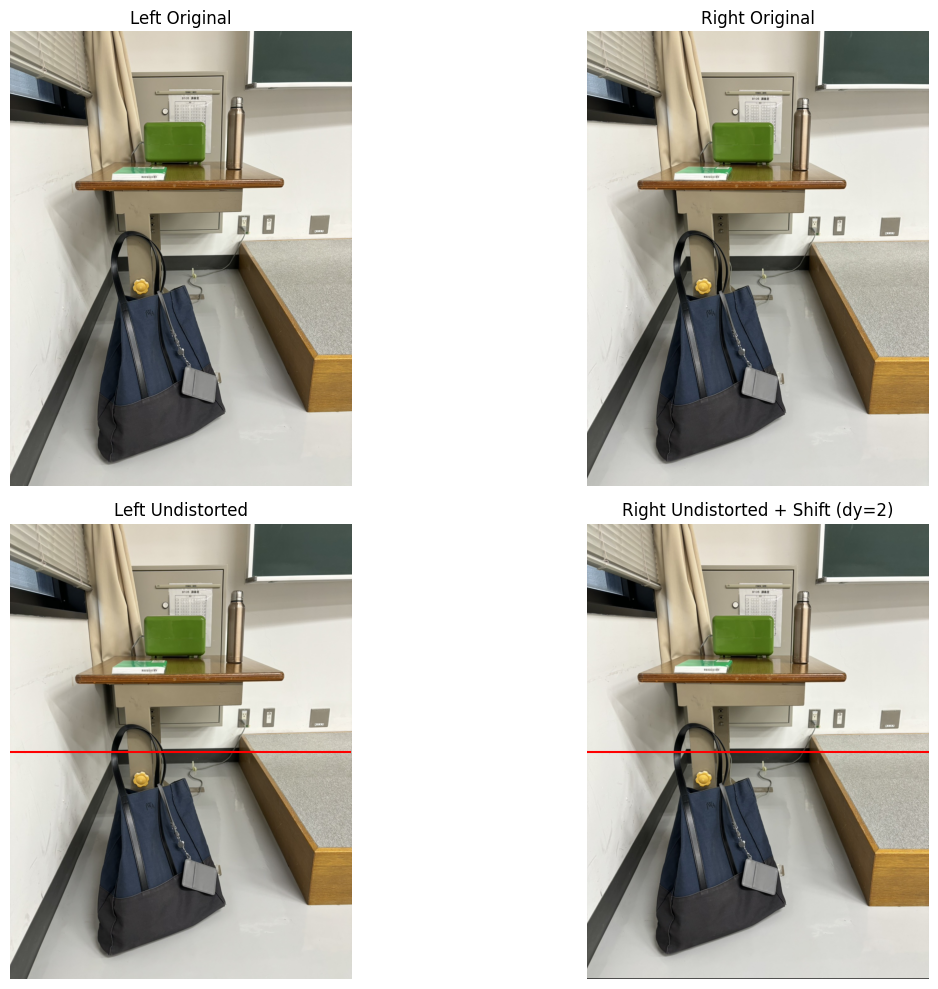

Saved final images to: /content/drive/MyDrive/Amazon project/processed_images


In [ ]:
import cv2
import os
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive

# ================= Drive =================
drive.mount('/content/drive')

# ================= Load COLOR images =================
left_color = cv2.imread("/content/drive/MyDrive/Amazon project/img/hidari.jpg")
right_color = cv2.imread("/content/drive/MyDrive/Amazon project/img/migi.jpg")

assert left_color is not None
assert right_color is not None

h, w, _ = left_color.shape
image_size = (w, h)

K = np.array([
    [1.15994113e+03, 0.00000000e+00, 5.46000399e+02],
 [0.00000000e+00, 1.15929016e+03, 7.32384585e+02],
 [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]
, dtype=np.float64)


D = 0.32 * np.array( [ 7.68506874e-03, -1.33669015e-01, -5.20174312e-05,  4.92592454e-04,
  0.00000000e+00], dtype=np.float64)

# ================= Undistort (COLOR) =================
new_K, roi = cv2.getOptimalNewCameraMatrix(K, D, image_size, alpha=0)

left_undist  = cv2.undistort(left_color,  K, D, None, new_K)
right_undist = cv2.undistort(right_color, K, D, None, new_K)

# ROI crop（端の黒を除去）
x, y, w_roi, h_roi = roi
left_undist  = left_undist[y:y+h_roi, x:x+w_roi]
right_undist = right_undist[y:y+h_roi, x:x+w_roi]

# ================= Convert to grayscale =================
left_gray  = cv2.cvtColor(left_undist,  cv2.COLOR_BGR2GRAY)
right_gray = cv2.cvtColor(right_undist, cv2.COLOR_BGR2GRAY)

# ================= Vertical shift estimation =================
def estimate_y_shift(left, right, search_range=20):
    h, w = left.shape
    y = h // 2

    patch_left = left[y-50:y+50, w//4:3*w//4].astype(np.int32)

    best_shift = 0
    best_score = np.inf

    for dy in range(-search_range, search_range + 1):
        y_start = y - 50 + dy
        y_end   = y + 50 + dy
        if y_start < 0 or y_end > h:
            continue

        patch_right = right[y_start:y_end, w//4:3*w//4].astype(np.int32)
        score = np.sum((patch_left - patch_right) ** 2)

        if score < best_score:
            best_score = score
            best_shift = dy

    return best_shift

dy = estimate_y_shift(left_gray, right_gray)
print("Estimated vertical shift dy:", dy)

# ================= Apply vertical shift (COLOR) =================
h2, w2, _ = left_undist.shape

M = np.float32([
    [1, 0, 0],
    [0, 1, -dy]
])

right_final = cv2.warpAffine(right_undist, M, (w2, h2))
left_final  = left_undist

# ================= Visualization =================
plt.figure(figsize=(14,10))

plt.subplot(2,2,1)
plt.imshow(cv2.cvtColor(left_color, cv2.COLOR_BGR2RGB))
plt.title("Left Original")
plt.axis("off")

plt.subplot(2,2,2)
plt.imshow(cv2.cvtColor(right_color, cv2.COLOR_BGR2RGB))
plt.title("Right Original")
plt.axis("off")

plt.subplot(2,2,3)
plt.imshow(cv2.cvtColor(left_final, cv2.COLOR_BGR2RGB))
plt.axhline(y=left_final.shape[0]//2, color='r')
plt.title("Left Undistorted")
plt.axis("off")

plt.subplot(2,2,4)
plt.imshow(cv2.cvtColor(right_final, cv2.COLOR_BGR2RGB))
plt.axhline(y=right_final.shape[0]//2, color='r')
plt.title(f"Right Undistorted + Shift (dy={dy})")
plt.axis("off")

plt.tight_layout()
plt.show()

# ================= Save results =================
output_folder = "/content/drive/MyDrive/Amazon project/processed_images"
os.makedirs(output_folder, exist_ok=True)

cv2.imwrite(os.path.join(output_folder, "left_final.png"), left_final)
cv2.imwrite(os.path.join(output_folder, "right_final.png"), right_final)

print("Saved final images to:", output_folder)


## 4. Disparity Map Computation Using Rectified and Undistorted Images

Finally, a disparity map is computed using rectified and undistorted stereo images.
Compared to the initial disparity map, this result benefits from:

- Reduced geometric distortion
- Improved correspondence accuracy
- Fewer mismatches and artifacts

This step demonstrates the effectiveness of the entire pipeline
and highlights the importance of proper calibration and preprocessing
for high-quality stereo vision results.


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


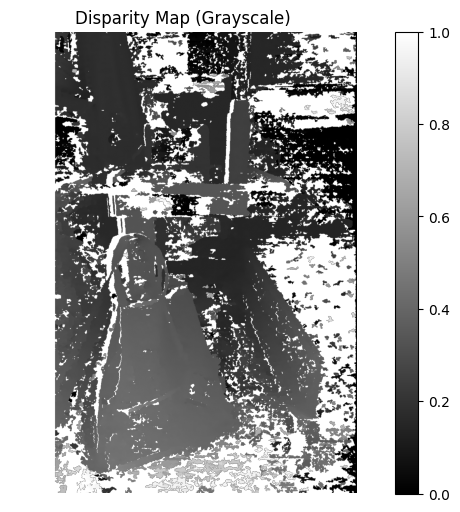

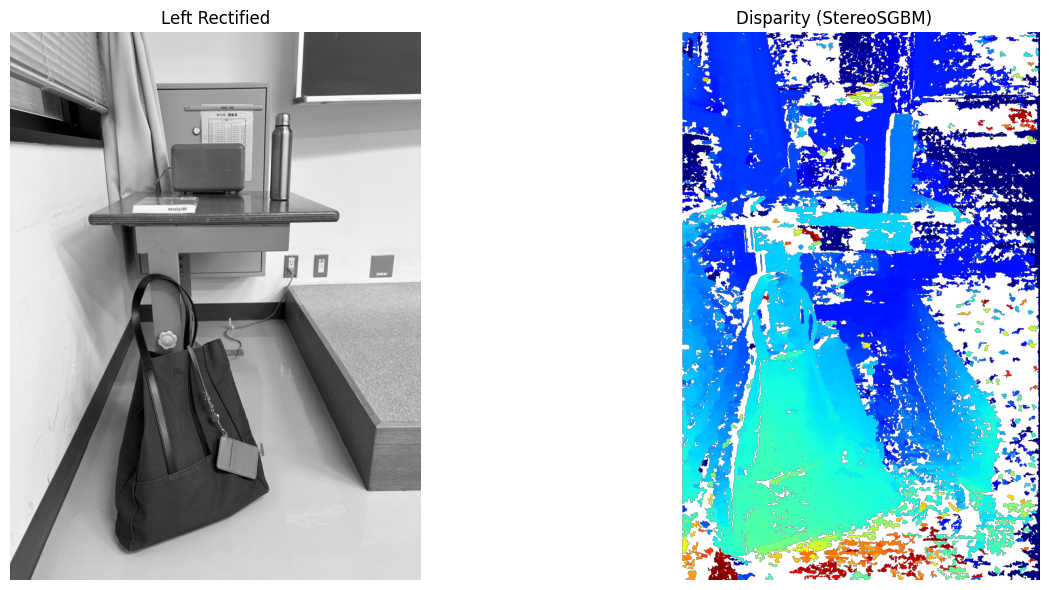

Saved disparity files:
 - disparity_float.npy
 - disparity_int16.png
 - disparity_vis.png


In [ ]:
import cv2
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from google.colab import drive


drive.mount('/content/drive')

# # read rectified images
# left_rect = cv2.imread("/content/drive/MyDrive/Amazon project/processed_images/left_reference_color.png", cv2.IMREAD_GRAYSCALE)
# right_rect = cv2.imread("/content/drive/MyDrive/Amazon project/processed_images/right_shifted_color.png", cv2.IMREAD_GRAYSCALE)

left_rect = cv2.imread("/content/drive/MyDrive/Amazon project/processed_images/left_final.png", cv2.IMREAD_GRAYSCALE)
right_rect = cv2.imread("/content/drive/MyDrive/Amazon project/processed_images/right_final.png", cv2.IMREAD_GRAYSCALE)


h, w = left_rect.shape

# creating disparity maps using StreoSGBM

min_disp = 0
num_disp = 16 *9
block_size = 7

stereo = cv2.StereoSGBM_create(
    minDisparity=min_disp,
    numDisparities=num_disp,
    blockSize=block_size,
    P1 = 8 * block_size * block_size,
    P2 = 16 * block_size * block_size,
    disp12MaxDiff=1,
    uniquenessRatio=0,
    speckleWindowSize=100,
    speckleRange=2
)

disp_sgbm = stereo.compute(left_rect, right_rect).astype(np.float32) / 16.0

disp_sgbm[disp_sgbm < 0] = np.nan
disp_norm = disp_sgbm.copy()
disp_norm = (disp_norm - np.nanmin(disp_norm)) / (np.nanmax(disp_norm) - np.nanmin(disp_norm))

plt.figure(figsize=(10,6))
plt.imshow(disp_norm, cmap='gray')  # グレースケール表示
plt.colorbar()
plt.title("Disparity Map (Grayscale)")
plt.axis("off")
plt.show()

plt.figure(figsize=(14,6))

plt.subplot(1, 2, 1)
plt.imshow(left_rect, cmap="gray")
plt.title("Left Rectified")
plt.axis("off")

plt.subplot(1, 2, 2)
plt.imshow(disp_sgbm, cmap="jet")
plt.title("Disparity (StereoSGBM)")
plt.axis("off")

plt.tight_layout()
plt.show()


output_dir = "/content/drive/MyDrive/Amazon project/processed_images"
os.makedirs(output_dir, exist_ok=True)

# ===============================
# 2. PNG保存用関数
# ===============================
def save_disparity_png(disp, path):
    disp_vis = disp.copy()
    disp_vis[np.isnan(disp_vis)] = 0
    disp_vis = cv2.normalize(disp_vis, None, 0, 255, cv2.NORM_MINMAX)
    disp_vis = disp_vis.astype(np.uint8)
    cv2.imwrite(path, disp_vis)

# ===============================
# Disparity save (NO MASK)
# ===============================

save_dir = "/content/drive/MyDrive/Amazon project/processed_images"
os.makedirs(save_dir, exist_ok=True)

# 1. 生の視差（float, 点群生成用）
np.save(
    os.path.join(save_dir, "disparity_float.npy"),
    disp_sgbm
)

# 2. OpenCV形式（×16, int16）
disp_int16 = np.zeros_like(disp_sgbm, dtype=np.int16)
valid = np.isfinite(disp_sgbm)
disp_int16[valid] = (disp_sgbm[valid] * 16.0).astype(np.int16)

cv2.imwrite(
    os.path.join(save_dir, "disparity_int16.png"),
    disp_int16
)

# 3. 可視化用（8bit）
disp_vis = disp_sgbm.copy()
disp_vis[~valid] = 0
disp_vis = cv2.normalize(disp_vis, None, 0, 255, cv2.NORM_MINMAX)
disp_vis = disp_vis.astype(np.uint8)

cv2.imwrite(
    os.path.join(save_dir, "disparity_vis.png"),
    disp_vis
)

print("Saved disparity files:")
print(" - disparity_float.npy")
print(" - disparity_int16.png")
print(" - disparity_vis.png")
